<h1>Import frameworks</h1>

In [1]:
from matplotlib import pyplot
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<h1>Read csv</h1>

The variable 'Human Development Index (value)' has the strongest correlation with a coefficient of 0.93.


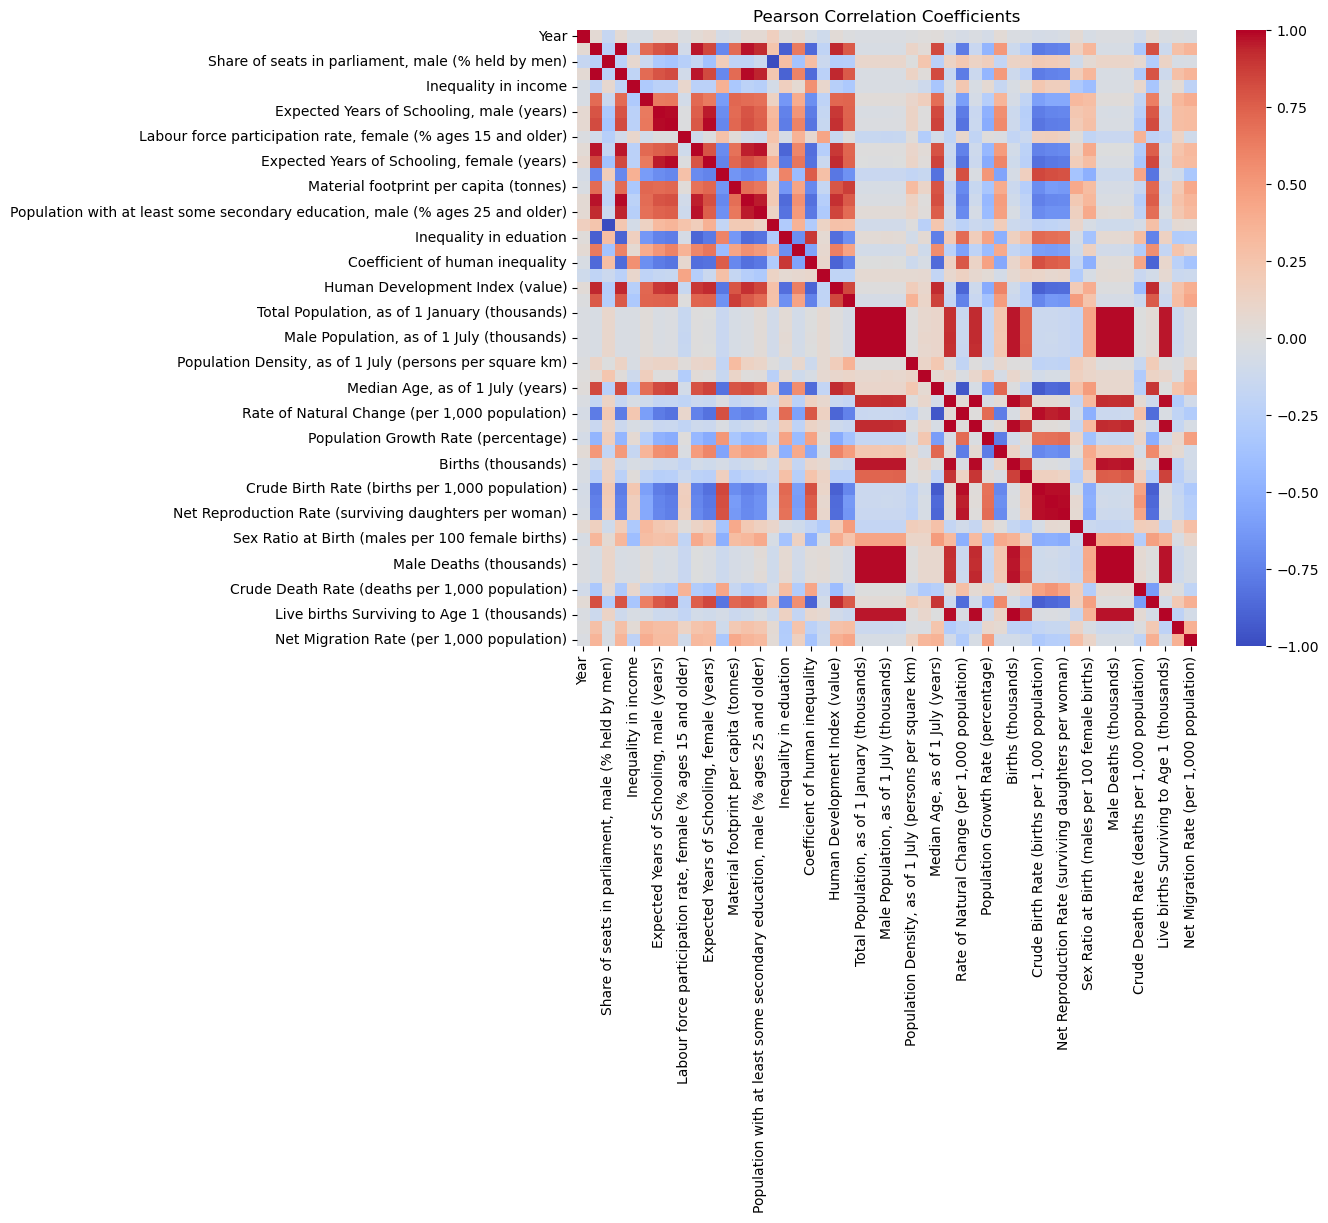

In [2]:
file_path = "../life_expectancy.csv"  
life_expectancy = pd.read_csv(file_path,  sep=',',).dropna()
#print(life_expectancy.head())

life_expectancy.set_index('Country', inplace=True)


X = life_expectancy.drop('Life Expectancy at Birth, both sexes (years)', axis=1)  # Features
y = life_expectancy['Life Expectancy at Birth, both sexes (years)']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Compute Pearson correlation coefficients
correlation_matrix = life_expectancy.corr(method='pearson')

# Extract correlation coefficients of the target variable (life expectancy)
correlation_with_life_expectancy = correlation_matrix['Life Expectancy at Birth, both sexes (years)']
# Remove the target variable from the correlation coefficients
correlation_without_life_expectancy = correlation_with_life_expectancy.drop('Life Expectancy at Birth, both sexes (years)')

# Find the variable with the highest absolute correlation coefficient
strongest_correlation_variable = correlation_without_life_expectancy.abs().idxmax()
strongest_correlation_coefficient = correlation_without_life_expectancy.abs().max()

print(f"The variable '{strongest_correlation_variable}' has the strongest correlation with a coefficient of {strongest_correlation_coefficient:.2f}.")


pyplot.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
pyplot.title('Pearson Correlation Coefficients')
pyplot.show()





<h1>Train model</h1>

The mean squared error is 10.62.


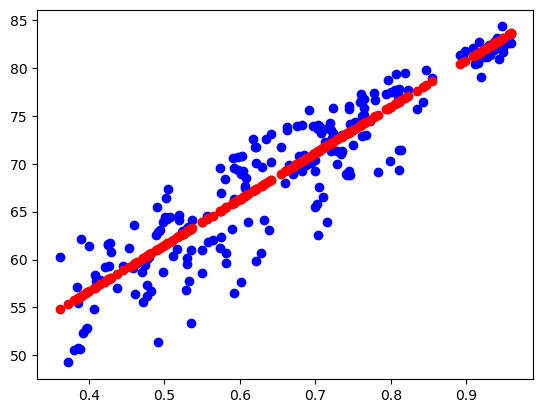

In [16]:

X_train_strongest = X_train[[strongest_correlation_variable]]
X_test_strongest = X_test[[strongest_correlation_variable]]

# Train a linear regression model using the variable with the strongest correlation
model = LinearRegression().fit(X_train_strongest, y_train)
# Make predictions
y_pred = model.predict(X_test_strongest)
pyplot.scatter(X_test_strongest, y_test, color='blue')
pyplot.scatter(X_test_strongest, y_pred, color='red')

mse = mean_squared_error(y_test, y_pred)
print(f"The mean squared error is {mse:.2f}.")

<h1>Non-linear relationship</h1>

The variable 'Median Age, as of 1 July (years)' has the strongest correlation with a coefficient of 0.92.


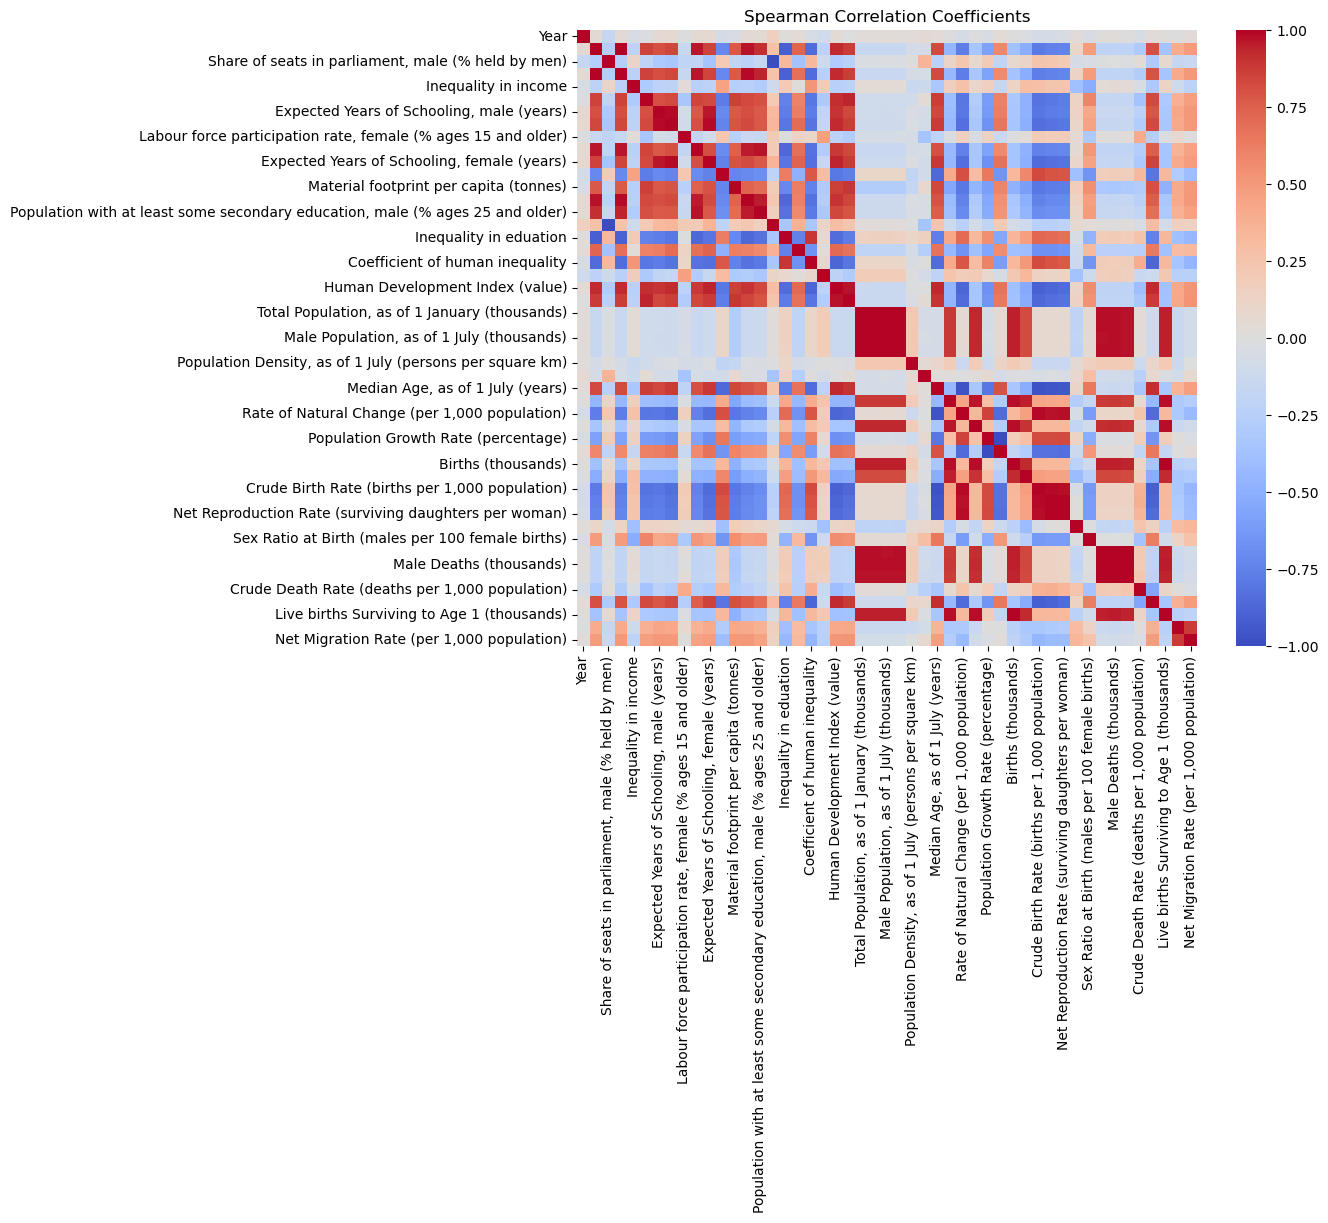

In [4]:


# Compute Spearman correlation coefficients
correlation_matrix_spearman = life_expectancy.corr(method='spearman')
correlation_with_life_expectancy_spearman = correlation_matrix_spearman['Life Expectancy at Birth, both sexes (years)']
correlation_matrix_spearman_clean = correlation_with_life_expectancy_spearman.drop(['Life Expectancy at Birth, both sexes (years)', strongest_correlation_variable])

# Find the variable with the highest absolute correlation coefficient
strongest_spearman_correlation_variable = correlation_matrix_spearman_clean.abs().idxmax()
strongest_spearman_correlation_coefficient = correlation_matrix_spearman_clean.abs().max()


print(f"The variable '{strongest_spearman_correlation_variable}' has the strongest correlation with a coefficient of {strongest_spearman_correlation_coefficient:.2f}.")


# Visualize Spearman correlation coefficients
pyplot.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, annot=False, cmap='coolwarm')
pyplot.title('Spearman Correlation Coefficients')
pyplot.show()


<h1>Linear relationship</h1>

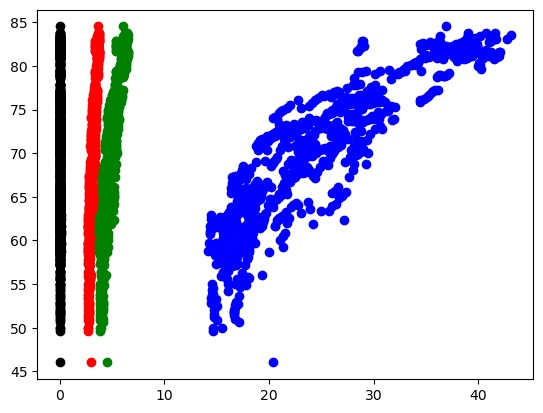

In [5]:
pd.options.mode.chained_assignment = None

X_train_strongest_spearman = X_train[[strongest_spearman_correlation_variable]]

X_train_strongest_spearman['log'] = np.log(X_train[[strongest_spearman_correlation_variable]])
X_train_strongest_spearman['sqrt'] = np.sqrt(X_train[[strongest_spearman_correlation_variable]])
X_train_strongest_spearman['reciprocal'] = 1/(X_train[[strongest_spearman_correlation_variable]])



pyplot.scatter(X_train_strongest_spearman.iloc[:, 0], y_train, color='blue')
pyplot.scatter(X_train_strongest_spearman['log'], y_train, color='red')
pyplot.scatter(X_train_strongest_spearman['sqrt'], y_train, color='green')
pyplot.scatter(X_train_strongest_spearman['reciprocal'], y_train, color='black')

#TODO calculare R^2


<h1>Multiple linear regression</h1>

In [15]:




correlation_matrix_spearman = life_expectancy.corr(method='spearman')
correlation_matrix_spearman = correlation_matrix_spearman.drop(['Life Expectancy at Birth, both sexes (years)', strongest_correlation_variable])

threshold = 0.85  
relevant_features = correlation_matrix_spearman[abs(correlation_matrix_spearman['Life Expectancy at Birth, both sexes (years)']) > threshold].index.tolist()

print(relevant_features)



model = LinearRegression()

X_train_mle = X_train[relevant_features]
X_test_mle = X_test[relevant_features]

model.fit(X_train_mle, y_train)

y_pred = model.predict(X_test_mle)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print('Coefficients:', model.coef_)


#TODO: comapre the results of the two models


['Expected Years of Schooling, female (years)', 'Coefficient of human inequality', 'Gross National Income Per Capita (2017 PPP$)', 'Median Age, as of 1 July (years)', 'Rate of Natural Change (per 1,000 population)', 'Crude Birth Rate (births per 1,000 population)', 'Total Fertility Rate (live births per woman)', 'Net Reproduction Rate (surviving daughters per woman)']
Mean Squared Error: 1.80112268132905
Coefficients: [ 1.75375307e-01 -7.03939951e-02  1.40166990e-05  6.06688284e-01
  1.54100282e+00 -2.03832472e+00  1.10519139e+00  5.30134969e+00]
